In [ ]:
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()
warnings.filterwarnings("ignore")

In [112]:
data = pd.read_csv("./max_data/max_dataset.csv")
data = data.fillna("Nil")
data.replace("0", "Nil", inplace=True)
data.replace("Nil", 0, inplace=True)
data.replace("Negative", 0, inplace=True)
data.replace("Normal", 0, inplace=True)
data.replace("Absent", 0, inplace=True)
data.replace("Yes", True, inplace=True)
data.replace("No", False, inplace=True)
data.replace("yes", True, inplace=True)
data.replace("no", False, inplace=True)
data.replace("True", True, inplace=True)
data.replace("False", False, inplace=True)
data = data.select_dtypes(include=[int, float, bool, object])
data = data.drop(columns=[data.columns[0], data.columns[1]])
data

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAD.drugallergies,DAAF.fooditemallergies,DAAS.skinallergies,DAAR.respiratoryallergies,DAAO.anyotherallergies,"HLSO.doyoucurrentlysmokeanytobaccoproductsdaily,suchascigarettes,cigarsorpipes?",...,LSTP.trophozoite,LAUB.uibc,LBRU.urea,LBRA.uricacid,LUSF.urinesugarfasting,LUSP.urinesugarpp,LUUB.urobilinogen,LABT.vitaminb12,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,30-Aug-1963,Male,0,True,0,0,Due to summer,0,0,False,...,0,0.0,12.4,5.0,0,0,0,0,15.2,1-2
1,1-Jan-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,0,0.0,0,0,0,0,0.0,1-2
2,8-Feb-1969,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.4,6.1,0,0,0,0,19.2,0-1
3,7-Aug-1963,Male,Asthma,True,0,0,0,Dust,0,False,...,0,0.0,28.7,5.0,0,0,0,0,16.0,2-4
4,1-Feb-1974,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.0,7.3,0,0,0,0,56.4,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,7-May-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,21.0,4.2,0,0,0,0,31.4,2-3
2688,6-Feb-1962,Male,0,False,0,0,0,0,0,True,...,0,0.0,22.6,6.3,0,0,0,0,14.4,2-4
2689,31-Oct-1972,Male,0,False,0,0,0,0,0,True,...,0,0.0,31.3,7.6,0,0,0,169,34.4,0-1
2690,25-Jul-1967,Male,0,False,0,0,0,0,0,False,...,0,0.0,24.1,7.5,0,0,0,0,33.2,1-2


In [113]:
# print the type of each column in the df
types = [data[col].dtype for col in data.columns]

# print value counts of types
print("Value counts of types:")
print(pd.Series(types).value_counts())

Value counts of types:
object     352
int64      110
bool        93
float64     74
Name: count, dtype: int64


In [32]:
def support_count(df, r):
    return ((df.iloc[r] != 0) & (df.iloc[r] != 0.0) & (df.iloc[r] != False)).sum()

In [33]:
def support_columns(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index].columns

In [34]:
def support(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index]

In [35]:
def support_values(df, r):
    return df[df.loc[r, df.loc[r].apply(lambda x: x != 0 and x != 0.0 and x != False)].index].iloc[r]

In [36]:
def support_count_c(df, c):
    return ((df.loc[:, c] != 0) & (df.loc[:, c] != 0.0) & (df.loc[:, c] != False)).sum()

In [37]:
def union_support_count(df, r1, r2):
    
    columns1 = support_columns(df, r1)
    columns2 = support_columns(df, r2)
    
    return len(list(set(columns1) | set(columns2)))

In [38]:
def union_support_columns(df, r1, r2):
    
    columns1 = support_columns(df, r1)
    columns2 = support_columns(df, r2)
    
    return list(set(columns1) | set(columns2))

In [454]:
# Sim(ri1, ri2) as defined by the paper
def similar(ri1, ri2):
    
    if type(ri1) is np.int64 or type(ri1) is int or type(ri1) is np.float64:
        ri1 = float(ri1)
    if type(ri2) is np.int64 or type(ri2) is int or type(ri2) is np.float64:
        ri2 = float(ri2)
    
    if type(ri1) != type(ri2):
        return 0
    elif (type(ri1) is np.float64 and type(ri2) is np.float64) or (type(ri1) is float and type(ri2) is float):
        return 1 if abs(abs(ri2) - abs(ri2)) <= 0.2 * ri1 else 0
    elif (type(ri1) is bool and type(ri2) is bool) or (type(ri1) is np.bool_ and type(ri2) is np.bool_):
        return 1 if ri1 == ri2 else 0
    elif type(ri1) is str and type(ri2) is str:
        return 1 if ri1 == ri2 else 0
    else:
        print(f"Uncaught, {type(ri1)}, {type(ri2)}")
        return 0

In [219]:
# Sim(r1, r2) as defined by the paper
def compute_similarity(df, r1, r2):
    
    similarity = pd.Series(union_support_columns(df, r1, r2)).apply(lambda column: similar(df.loc[r1, column], df.loc[r2, column])).sum()
    sim_score = similarity/union_support_count(df, r1, r2) if union_support_count(df, r1, r2) != 0 else 0
    return sim_score

In [41]:
# For the adversary's information, Aux(r). This randomly selects the columns that they know about
# We can consider a different method as well, based on some information measure, for eg some entropy measure or the number of rows that each column has a valid value for
def auxillary_columns(df, r, count):
    
    aux = random.sample(list(support_columns(df, r)), min(count, support_count(df, r)))
    return aux

In [42]:
# Aux(r) as defined by the paper
def auxillary(df, r, count):
    
    aux = df.loc[r, auxillary_columns(df, r, count)]
    return aux

In [43]:
# Score(aux, r') as defined by the paper
def score(df, aux, r0):
    
    scores = pd.Series(aux.index).apply(lambda column: similar(aux.loc[column], df.loc[r0, column]))
    return scores.sum()/len(aux.index) if len(aux.index) != 0 else 0


In [450]:
# Robust Score(aux, r') as defined by the paper
def score_robust(df, aux, r0):
    
    scores = pd.Series(aux.index).apply(lambda column: (math.e**similar(aux.loc[column], df.loc[r0, column]))/max(1, math.log(support_count_c(df, column))))
    return scores.sum()/len(aux.index) if len(aux.index) != 0 else 0


In [45]:
# Best guess as defined by the paper
def best_guess(candidates, eccentricity):
    sorted_candidates = candidates.sort_values(ascending=False)
    heuristic = (sorted_candidates.index[0] - sorted_candidates.index[1])/candidates.std()
    return sorted_candidates.index[0] if heuristic >= eccentricity else None

In [46]:
# Matching criterion as defined by the paper
def match(df, aux, alpha):
    
    candidates = pd.Series(df.index).apply(lambda row: score(df, aux, row))
    candidates = candidates[candidates >= alpha]
    if candidates.empty:
        return pd.Series({"-1": 0})
    return candidates

In [47]:
# Robust matching criterion as defined by the paper
def match_robust(df, aux, alpha):
    
    candidates = pd.Series(df.index).apply(lambda row: score_robust(df, aux, row))
    if candidates.empty:
        return pd.Series({"-1": 0})
    elif candidates.shape[0] > 1:
        return best_guess(candidates, 1.5)
    return candidates

In [49]:
# Scoreboard() as defined by the paper
def scoreboard(df, count):
    
    aux_series = pd.Series(df.index).apply(lambda r1: auxillary(df, r1, count))
    scores = pd.DataFrame(index=df.index, columns=df.index)
    
    for r1 in tqdm(list(df.index)):
        scores.loc[r1, :] = pd.Series(df.index).apply(lambda r2: score(df, aux_series.loc[r1, ~aux_series.loc[r1].isna()], r2))
    
    return scores

In [50]:
# ScoreboardRH() as defined by the paper
def scoreboard_robust(df, count):
    
    aux_series = pd.Series(df.index).apply(lambda r1: auxillary(df, r1, count))
    scores = pd.DataFrame(index=df.index, columns=df.index)
    
    for r1 in tqdm(list(df.index)):
        scores.loc[r1, :] = pd.Series(df.index).apply(lambda r2: score_robust(df, aux_series.loc[r1, ~aux_series.loc[r1].isna()], r2))
            
    return scores

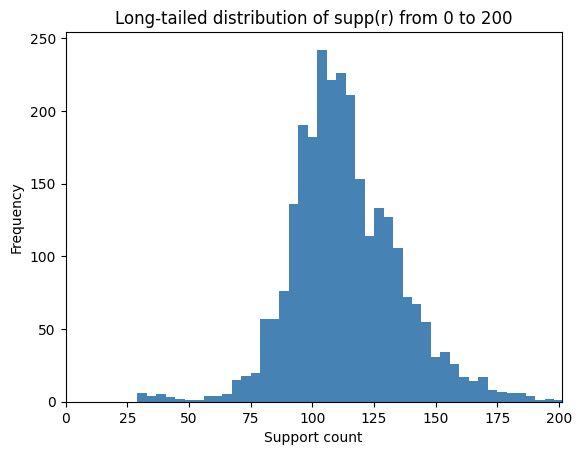

In [51]:
support_counts = pd.Series(df.index).apply(lambda x: support_count(df, x))
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(r) from 0 to 200", xlim=(0, 201), xlabel="Support count", ylabel="Frequency")
plt.show()

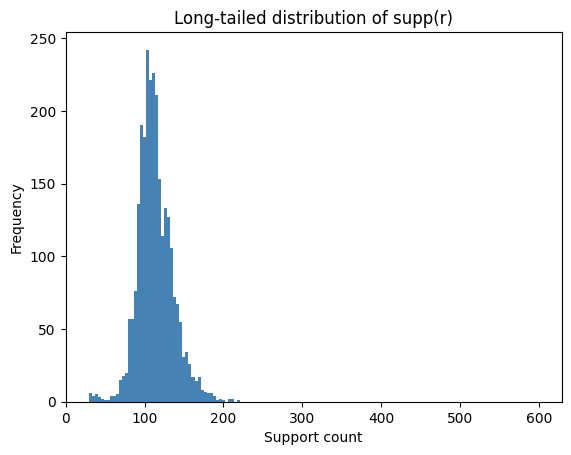

In [52]:
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(r)", xlim=(0, len(df.columns)), xlabel="Support count", ylabel="Frequency")
plt.show()

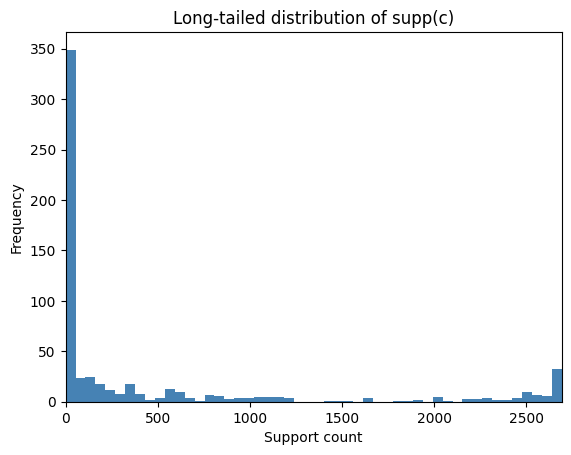

In [53]:
support_counts = pd.Series(df.columns).apply(lambda x: support_count_c(df, x))
support_counts.plot(kind="hist", bins=50, color="steelblue", title="Long-tailed distribution of supp(c)", xlim=(0, len(df)), xlabel="Support count", ylabel="Frequency")
plt.show()

In [448]:
df3 = data.loc[:10, [col for col in data.columns]]
df3 

,PDOB.dob,PGDR.gender,PCHC.chiefcomplains,DAAA.doyouhaveanyallergies?,DAAD.drugallergies,DAAF.fooditemallergies,DAAS.skinallergies,DAAR.respiratoryallergies,DAAO.anyotherallergies,"HLSO.doyoucurrentlysmokeanytobaccoproductsdaily,suchascigarettes,cigarsorpipes?",...,LSTP.trophozoite,LAUB.uibc,LBRU.urea,LBRA.uricacid,LUSF.urinesugarfasting,LUSP.urinesugarpp,LUUB.urobilinogen,LABT.vitaminb12,LBLV.vldlcholesterol,LEEK.whitebloodcell
0,30-Aug-1963,Male,0,True,0,0,Due to summer,0,0,False,...,0,0.0,12.4,5.0,0,0,0,0,15.2,1-2
1,1-Jan-1975,Female,0,False,0,0,0,0,0,False,...,0,0.0,0,0.0,0,0,0,0,0.0,1-2
2,8-Feb-1969,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.4,6.1,0,0,0,0,19.2,0-1
3,7-Aug-1963,Male,Asthma,True,0,0,0,Dust,0,False,...,0,0.0,28.7,5.0,0,0,0,0,16.0,2-4
4,1-Feb-1974,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.0,7.3,0,0,0,0,56.4,0-1
5,2-Jul-1973,Male,0,False,0,0,0,0,0,False,...,0,243.0,39.7,6.1,0,0,0,183,28.8,2-4
6,7-Sep-1945,Female,HTN,False,0,0,0,0,0,False,...,0,0.0,20.0,4.7,0,0,0,0,65.2,1-2
7,7-Dec-1995,Female,0,False,0,0,0,0,0,False,...,0,0.0,17.5,2.5,0,0,0,193,12.2,2-4
8,1-Jan-1975,Male,0,False,0,0,0,0,0,False,...,0,0.0,33.6,5.2,0,0,0,0,19.2,1-2
9,19-Jan-1977,Male,0,False,0,0,0,0,0,False,...,0,0.0,17.1,7.5,0,0,0,0,33.4,1-2


In [55]:
similar(df3.iloc[0, 1], df3.iloc[3, 1])

1

In [56]:
compute_similarity(df3, 0, 3)

0.23076923076923078

In [462]:
# nn = pd.Series(df3.index).iloc[:20].progress_apply(lambda x: max([compute_similarity(df3, x, i) for i in df3.index if i != x]))
# nn.to_csv("./nearestneighbours.csv")
nn = pd.read_csv("./results/nearestneighbours.csv", index_col=0)
nn.head()

,0
0,0.263158
1,0.224490
2,0.256410
3,0.258621
4,0.256637


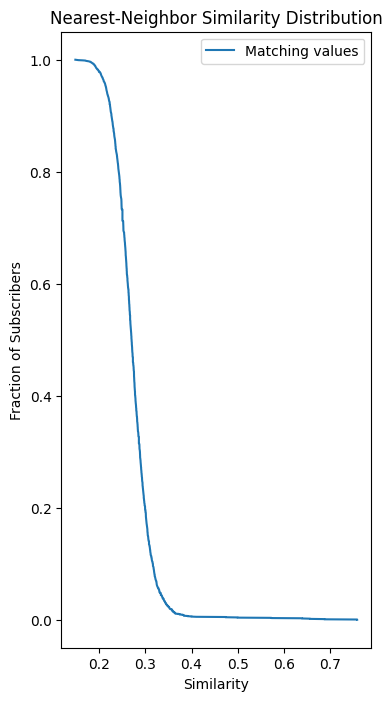

In [466]:
sorted_nn = nn.reset_index().sort_values(by="0", ascending=False)
fractions = np.arange(1, len(sorted_nn) + 1) / len(sorted_nn)

plt.figure(figsize=(4, 8))
plt.plot(sorted_nn["0"].values, fractions, marker='', label='Matching values')
plt.xlabel("Similarity")
plt.ylabel("Fraction of Subscribers")
plt.title("Nearest-Neighbor Similarity Distribution")
plt.legend(fontsize=10)
plt.show()

In [59]:
auxillary(df3, 54, 4)

IRXO.x-raychestpa                              True
LHCW.rdw                                       16.1
LHCZ.packedcellvolume                          36.2
HDVA.adultvaccination    Covid Vaccination- 1, 2, 3
Name: 54, dtype: object

In [60]:
score(df3, auxillary(df3, 54, 4), 0)

0.25

In [62]:
match(df3, auxillary(df3, 3, 10), 0.5)

3       1.0
151     0.5
399     0.5
1005    0.5
1072    0.5
dtype: float64

In [ ]:
# results10 = scoreboard(df3, 10)
results10 = pd.read_csv(f"./results/r2/resultscount10.csv")
results10.iloc[:200, :200]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.0,0.0,0.2,0.3,0.1,0.3,0.2,0.1,0.1,0.2,...,0.2,0.1,0.3,0.3,0.1,0.2,0.1,0.3,0.3,0.2
1,0.2,1.0,0.3,0.3,0.5,0.3,0.3,0.4,0.5,0.2,...,0.4,0.5,0.3,0.3,0.4,0.3,0.4,0.2,0.3,0.1
2,0.1,0.1,1.0,0.4,0.2,0.2,0.2,0.2,0.1,0.3,...,0.1,0.1,0.1,0.1,0.2,0.3,0.1,0.2,0.1,0.2
3,0.2,0.1,0.2,1.0,0.2,0.0,0.1,0.1,0.3,0.0,...,0.1,0.3,0.2,0.2,0.2,0.1,0.0,0.3,0.1,0.0
4,0.3,0.0,0.2,0.3,1.0,0.1,0.2,0.2,0.3,0.2,...,0.2,0.2,0.3,0.2,0.2,0.2,0.1,0.2,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.4,0.3,0.3,0.4,0.4,0.3,0.4,0.4,0.4,0.3,...,0.4,0.4,0.5,0.4,0.4,1.0,0.4,0.3,0.4,0.2
196,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.1,0.0,0.2,0.0,1.0,0.0,0.1,0.0
197,0.3,0.0,0.2,0.3,0.1,0.2,0.1,0.2,0.2,0.2,...,0.2,0.2,0.3,0.3,0.1,0.3,0.3,1.0,0.2,0.2
198,0.1,0.0,0.1,0.2,0.1,0.2,0.3,0.0,0.3,0.1,...,0.1,0.3,0.2,0.2,0.1,0.1,0.1,0.1,1.0,0.1


<Axes: >

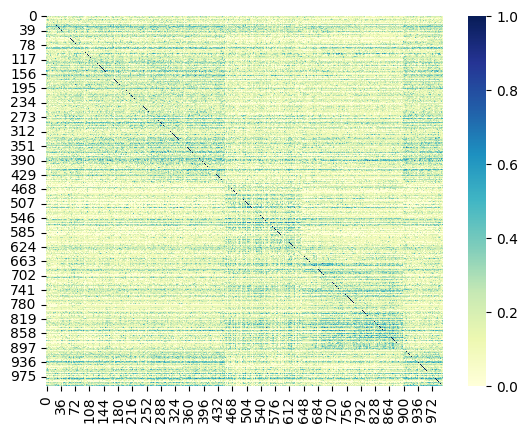

In [327]:
sns.heatmap(results10.iloc[:1000, :1000].astype(float), annot=False, cmap="YlGnBu", linewidths=0) # count=10

In [409]:
results = ["" for _ in range(16)]
for i in range(1, 15):
    results[i] = pd.read_csv(f"./results/r3/resultscount{i}.csv")

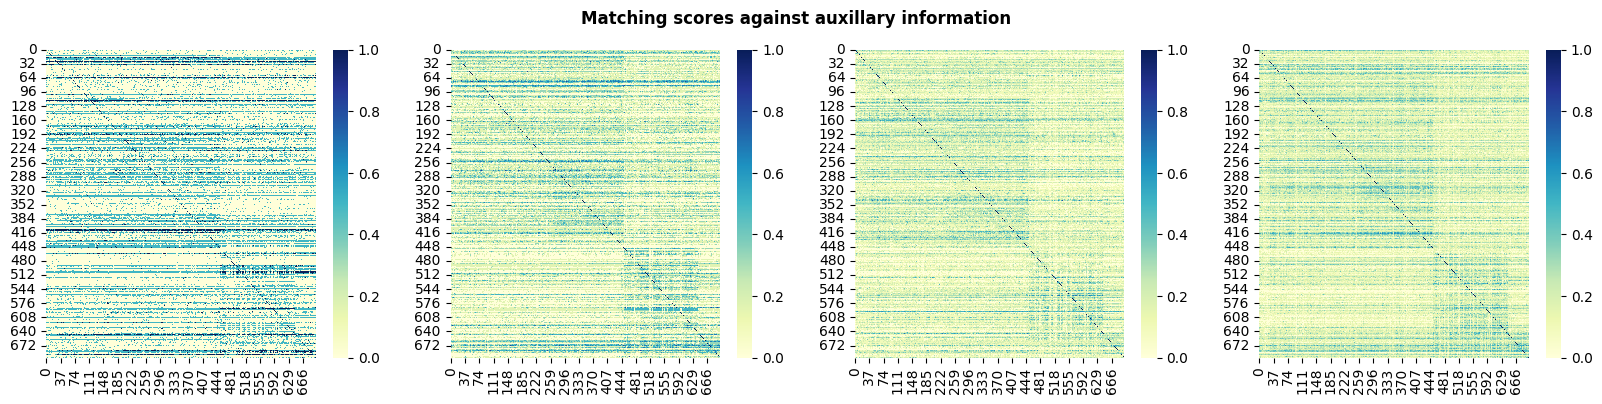

In [417]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))
fig.suptitle("Matching scores against auxillary information", weight="bold", x=0.5)
sns.heatmap(results[2].iloc[:700, :700].astype(float), annot=False, cmap="YlGnBu", linewidths=0, ax=axes[0])
sns.heatmap(results[6].iloc[:700, :700].astype(float), annot=False, cmap="YlGnBu", linewidths=0, ax=axes[1])
sns.heatmap(results[10].iloc[:700, :700].astype(float), annot=False, cmap="YlGnBu", linewidths=0, ax=axes[2])
sns.heatmap(results[14].iloc[:700, :700].astype(float), annot=False, cmap="YlGnBu", linewidths=0, ax=axes[3])
plt.show()

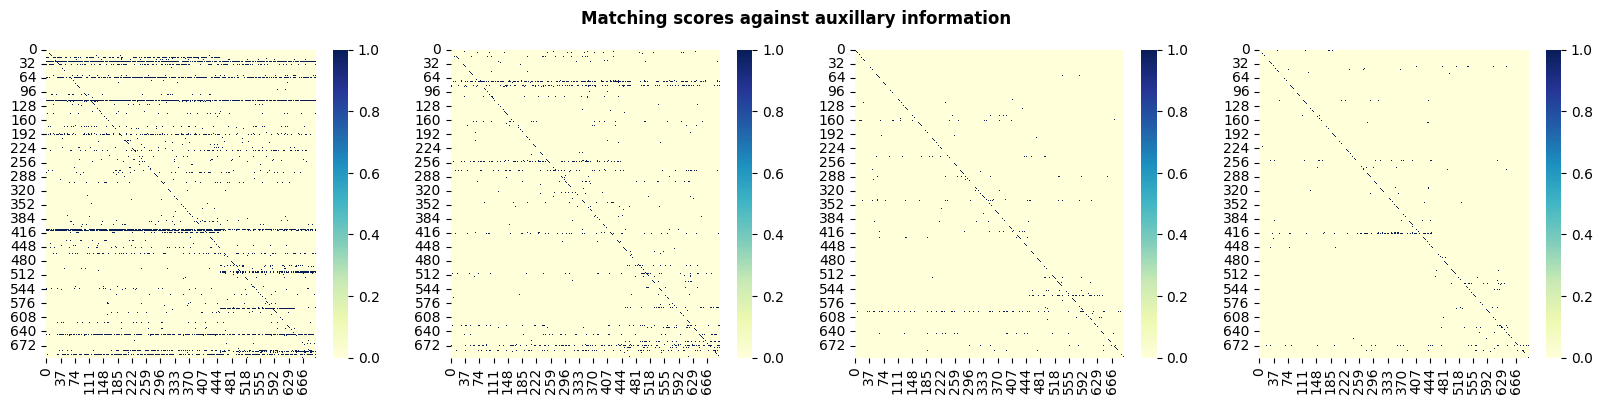

In [418]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))
fig.suptitle("Matching scores against auxillary information", weight="bold", x=0.5)
sns.heatmap(results[2].iloc[:700, :700].astype(float) > 0.5, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[0])
sns.heatmap(results[6].iloc[:700, :700].astype(float) > 0.5, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[1])
sns.heatmap(results[10].iloc[:700, :700].astype(float) > 0.5, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[2])
sns.heatmap(results[14].iloc[:700, :700].astype(float) > 0.5, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[3])
plt.show()

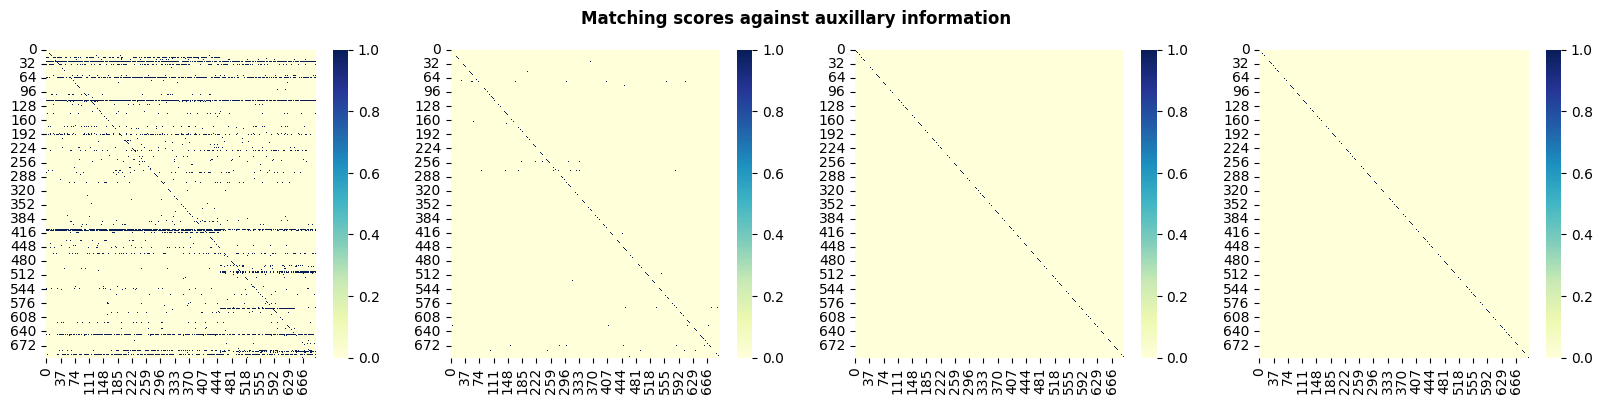

In [441]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))
fig.suptitle("Matching scores against auxillary information", weight="bold", x=0.5)
sns.heatmap(results[2].iloc[:700, :700].astype(float) > 0.8, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[0])
sns.heatmap(results[6].iloc[:700, :700].astype(float) > 0.8, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[1])
sns.heatmap(results[10].iloc[:700, :700].astype(float) > 0.8, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[2])
sns.heatmap(results[14].iloc[:700, :700].astype(float) > 0.8, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[3])
plt.show()

In [ ]:
line_values = [[0 for _ in range(1, 16)] for _ in range(4)]

for i in tqdm(range(1, 15)):
    line_values[0][i] = sum(results[i].iloc[j, j] == results[i].iloc[j].max() for j in range(len(results[i])))
    line_values[1][i] = sum(results[i].iloc[j, j] == results[i].iloc[j].max() and sum(results[i].iloc[j, :] > 0.8) == 1 for j in range(len(results[i])))
    line_values[2][i] = sum(results[i].iloc[j, j] == results[i].iloc[j].max() and sum(results[i].iloc[j, :] > 0.6) == 1 for j in range(len(results[i])))
    line_values[3][i] = sum(results[i].iloc[j, j] == results[i].iloc[j].max() and sum(results[i].iloc[j, :] > 0.5) == 1 for j in range(len(results[i])))
    
line_values = [[x/len(df3)*100 for x in line_values[i]] for i in range(4)]

In [446]:
line_values[1]

[0.0,
 7.949479940564635,
 37.89004457652303,
 71.2852897473997,
 88.22436849925705,
 95.43090638930164,
 86.44130757800892,
 95.83952451708767,
 98.14264487369985,
 99.10846953937593,
 99.73997028231798,
 99.29420505200595,
 99.59138187221397,
 99.92570579494799,
 99.888558692422]

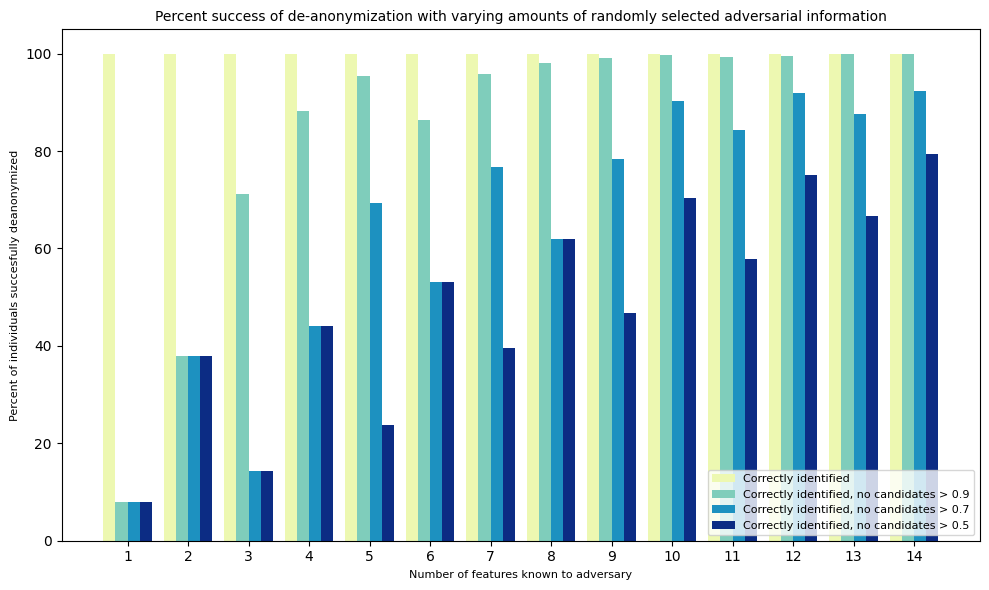

In [439]:
x = np.arange(len(line_values[0])-1)
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width*1.5, line_values[0][1:], width, label='Correctly identified', color='#edf8b1')
bars2 = ax.bar(x - width*0.5, line_values[1][1:], width, label='Correctly identified, no candidates > 0.9', color='#7fcdbb')
bars3 = ax.bar(x + width*0.5, line_values[2][1:], width, label='Correctly identified, no candidates > 0.7', color='#1d91c0')
bars4 = ax.bar(x + width*1.5, line_values[3][1:], width, label='Correctly identified, no candidates > 0.5', color='#0c2c84')

ax.set_xlabel('Number of features known to adversary', fontsize=8)
ax.set_ylabel('Percent of individuals succesfully deanonymized', fontsize=8)
ax.set_title('Percent success of de-anonymization with varying amounts of randomly selected adversarial information', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels([str(x) for x in range(1, 15)])
ax.legend(fontsize=8, loc="lower right")

plt.tight_layout()
plt.show()

In [477]:
results_r = ["" for _ in range(11)]
for i in range(1, 11):
    results_r[i] = pd.read_csv(f"./results/r3r/resultscount{i}_robust.csv")

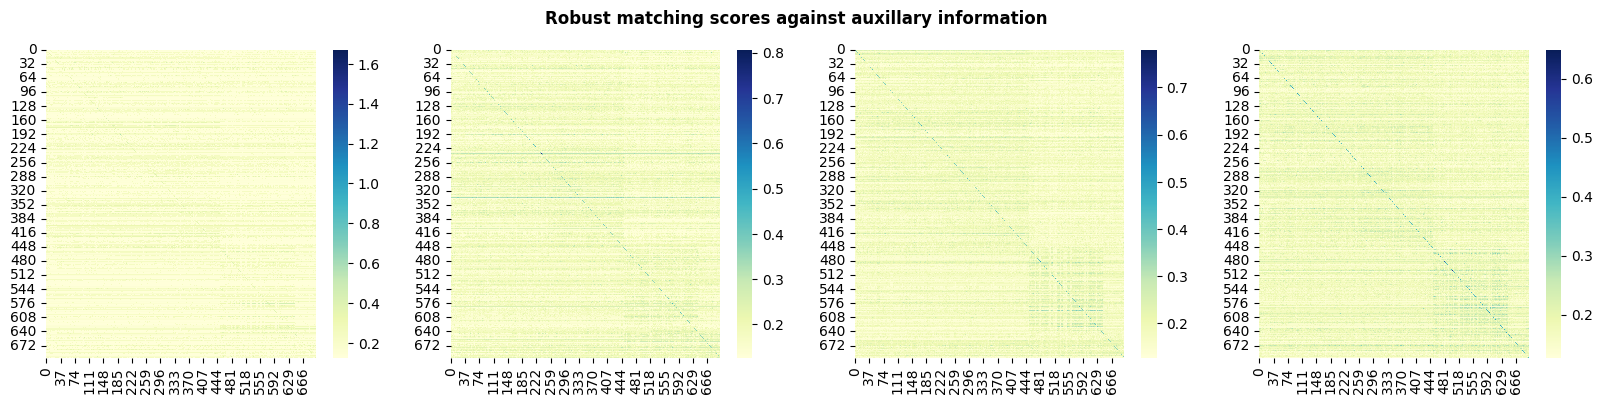

In [478]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))
fig.suptitle("Robust matching scores against auxillary information", weight="bold", x=0.5)
sns.heatmap(results_r[2].iloc[:700, :700].astype(float), annot=False, cmap="YlGnBu", linewidths=0, ax=axes[0])
sns.heatmap(results_r[6].iloc[:700, :700].astype(float), annot=False, cmap="YlGnBu", linewidths=0, ax=axes[1])
sns.heatmap(results_r[8].iloc[:700, :700].astype(float), annot=False, cmap="YlGnBu", linewidths=0, ax=axes[2])
sns.heatmap(results_r[10].iloc[:700, :700].astype(float), annot=False, cmap="YlGnBu", linewidths=0, ax=axes[3])
plt.show()

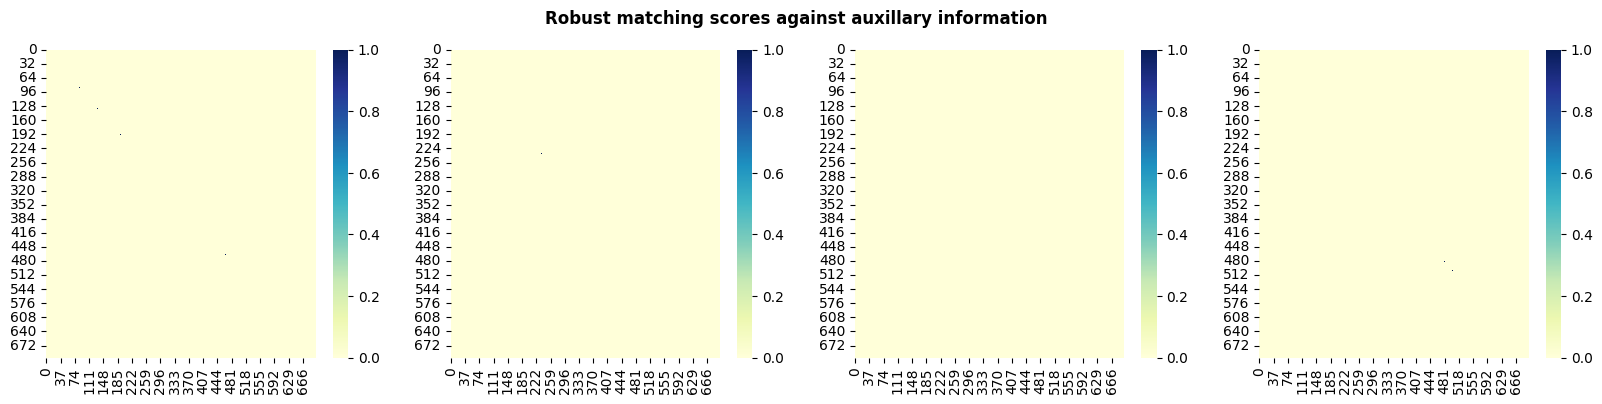

In [482]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))
fig.suptitle("Robust matching scores against auxillary information", weight="bold", x=0.5)
sns.heatmap(results_r[2].iloc[:700, :700].astype(float) > 0.5, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[0])
sns.heatmap(results_r[6].iloc[:700, :700].astype(float) > 0.5, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[1])
sns.heatmap(results_r[8].iloc[:700, :700].astype(float) > 0.5, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[2])
sns.heatmap(results_r[10].iloc[:700, :700].astype(float) > 0.5, annot=False, cmap="YlGnBu", linewidths=0, ax=axes[3])
plt.show()

In [ ]:
line_values_r = [[0 for _ in range(1, 12)] for _ in range(4)]

for i in tqdm(range(1, 11)):
    line_values_r[0][i] = sum(results_r[i].iloc[j, j] == results_r[i].iloc[j].max() for j in range(len(results_r[i])))
    line_values_r[1][i] = sum(results_r[i].iloc[j, j] == results_r[i].iloc[j].max() and sum(results_r[i].iloc[j, :] > 2) == 1 for j in range(len(results_r[i])))
    line_values_r[2][i] = sum(results_r[i].iloc[j, j] == results_r[i].iloc[j].max() and sum(results_r[i].iloc[j, :] > 1) == 1 for j in range(len(results_r[i])))
    line_values_r[3][i] = sum(results_r[i].iloc[j, j] == results_r[i].iloc[j].max() and sum(results_r[i].iloc[j, :] > 0.8) == 1 for j in range(len(results_r[i])))

line_values_r = [[(x/2692)*100 for x in line_values_r[i]] for i in range(4)]

100%|██████████| 10/10 [00:24<00:00,  2.48s/it]

[0, 2692, 2692, 2692, 2692, 2692, 2692, 2692, 2692, 2692, 2692]


In [503]:
line_values_r[0]

[0.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]

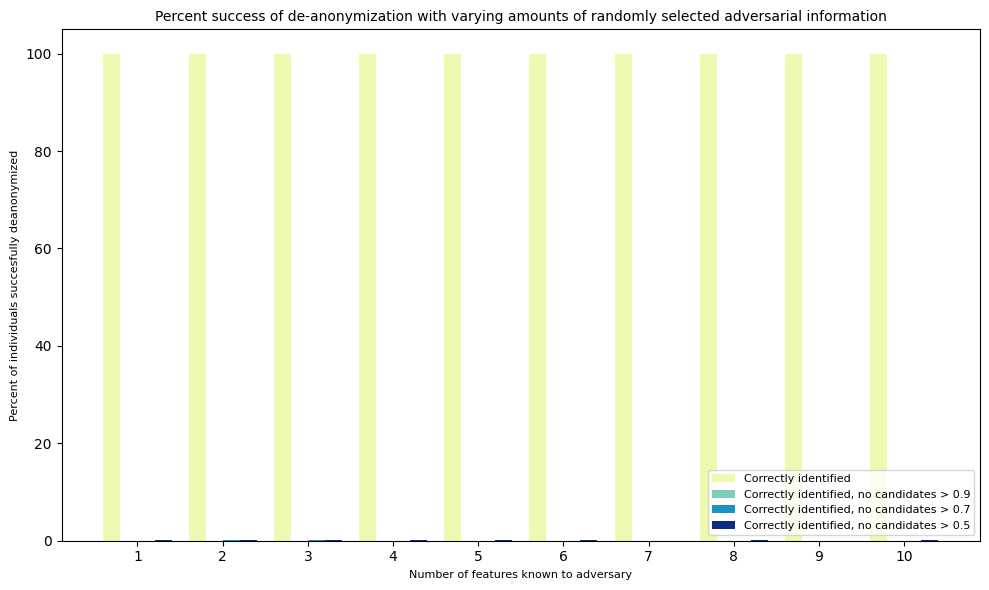

In [501]:
x = np.arange(len(line_values_r[0])-1)
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width*1.5, line_values_r[0][1:], width, label='Correctly identified', color='#edf8b1')
bars2 = ax.bar(x - width*0.5, line_values_r[1][1:], width, label='Correctly identified, no candidates > 0.9', color='#7fcdbb')
bars3 = ax.bar(x + width*0.5, line_values_r[2][1:], width, label='Correctly identified, no candidates > 0.7', color='#1d91c0')
bars4 = ax.bar(x + width*1.5, line_values_r[3][1:], width, label='Correctly identified, no candidates > 0.5', color='#0c2c84')

ax.set_xlabel('Number of features known to adversary', fontsize=8)
ax.set_ylabel('Percent of individuals succesfully deanonymized', fontsize=8)
ax.set_title('Percent success of de-anonymization with varying amounts of randomly selected adversarial information', fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels([str(x) for x in range(1, 11)])
ax.legend(fontsize=8, loc="lower right")

plt.tight_layout()
plt.show()

In [420]:
# supports = results[1].progress_apply(lambda col: col.index.to_series().apply(lambda row_idx: union_support_count(df3, row_idx, col.name)))
# supports.to_csv("./results2.csv")
supports = pd.read_csv(f"./results/results2.csv", index_col=0)
supports.iloc[:200, :200]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,100,109,113,117,106,137,133,116,109,122,...,110,134,124,123,120,123,118,119,105,140
1,109,39,117,119,113,122,118,100,107,111,...,107,129,118,121,118,111,100,113,97,124
2,113,117,108,116,114,142,135,121,114,130,...,118,140,132,129,124,127,126,127,113,139
3,117,119,116,110,119,147,139,129,116,132,...,119,139,132,131,125,131,127,128,114,141
4,106,113,114,119,104,141,134,117,113,123,...,114,139,128,128,124,124,122,123,109,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,123,111,127,131,124,143,140,121,127,125,...,123,148,136,143,126,103,119,128,118,132
196,118,100,126,127,122,132,135,117,116,121,...,112,138,124,133,117,119,92,118,106,136
197,119,113,127,128,123,137,129,130,117,125,...,113,130,122,122,120,128,118,104,104,140
198,105,97,113,114,109,128,122,116,103,116,...,99,120,112,115,110,118,106,104,88,132


<Axes: >

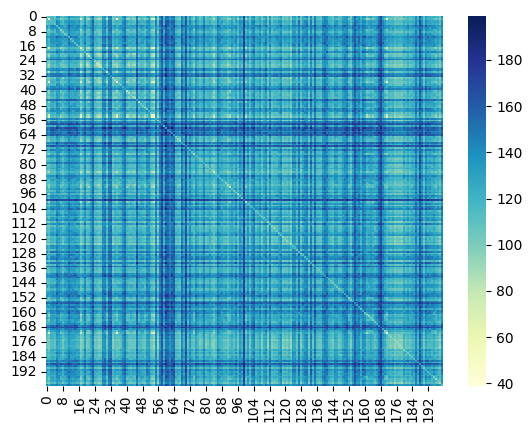

In [440]:
sns.heatmap(supports.iloc[:200, :200].astype(float), annot=False, cmap="YlGnBu", linewidths=0) # count=100